# Study of the variability of Dahu cluster

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_archive(archive_name, mode, exp_id, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode %s, exp %d' % (mode, exp_id))
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id)
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['file', 'line', 'function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    if mode == 'reality':
        df_links = None
    else:
        df_links = read_smpi_link(archive_name, 'trace_mpi_%d.csv' % exp_id)
    df['duration'] = df['end'] - df['start']
    df['exp_id'] = exp_id
    return df, df_links

reality_file = 'grenoble_2018-12-17_1828852.zip'

i = 0
traces = []
while True:
    try:
        trace_reality, link_reality = read_archive(reality_file, 'reality', i)
    except KeyError:
        break
    traces.append(trace_reality)
    i += 1

traces = pandas.concat(traces)

# Mode reality, exp 0
	BLAS trace: 524470 lines
	MPI  trace: 844024 lines
Removed 524998 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode reality, exp 1
	BLAS trace: 1418360 lines
	MPI  trace: 1737914 lines
Removed 1418888 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode reality, exp 2
	BLAS trace: 411720 lines
	MPI  trace: 731274 lines
Removed 412248 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode reality, exp 3
	BLAS trace: 590292 lines
	MPI  trace: 909846 lines
Removed 590820 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode reality, exp 4
	BLAS trace: 380834 lines
	MPI  trace: 700388 lines
Removed 381362 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode 

## Performance variability of HPL

In [2]:
hpl_result = read_csv(reality_file, 'results.csv')
hpl_result['exp_id'] = range(len(hpl_result))
hpl_result

,rfact,time,residual,swap,proc_p,gflops,pfact,process_per_node,depth,block_size,matrix_size,mem_align,bcast,proc_q,thread_per_process,exp_id
0,2,36.99,0.001732,0,2,2253.0,1,1,1,128,50000,8,2,4,32,0
1,2,33.93,0.001607,0,2,2456.0,1,1,1,128,50000,8,2,4,32,1
2,2,35.59,0.001744,0,2,2342.0,1,1,1,128,50000,8,2,4,32,2
3,2,37.09,0.001705,0,2,2247.0,1,1,1,128,50000,8,2,4,32,3
4,2,32.60,0.001539,0,2,2556.0,1,1,1,128,50000,8,2,4,32,4
5,2,32.37,0.001687,0,2,2574.0,1,1,1,128,50000,8,2,4,32,5
6,2,40.10,0.001648,0,2,2078.0,1,1,1,128,50000,8,2,4,32,6
7,2,35.69,0.001522,0,2,2335.0,1,1,1,128,50000,8,2,4,32,7
8,2,36.27,0.001669,0,2,2297.0,1,1,1,128,50000,8,2,4,32,8
9,2,34.00,0.001604,0,2,2451.0,1,1,1,128,50000,8,2,4,32,9


In [3]:
traces_summary = traces.groupby(['exp_id', 'function'])[['duration']].agg(['count', 'sum'])
traces_summary.columns = traces_summary.columns.droplevel()
traces_summary = traces_summary.reset_index()
traces_summary.head(n=10)

,exp_id,function,count,sum
0,0,MPI_Bcast,16,0.080378
1,0,MPI_Irecv,103882,1.857949
2,0,MPI_Recv,3682,23.409467
3,0,MPI_Send,107564,86.872126
4,0,MPI_Wait,103882,1.854380
5,0,dgemm,262235,112.843692
6,0,dtrsm,262235,2.842374
7,1,MPI_Bcast,16,0.973448
8,1,MPI_Irecv,103882,1.313817
9,1,MPI_Recv,3682,18.689834


In [4]:
df = traces_summary.set_index('exp_id').join(hpl_result.set_index('exp_id')[['time', 'gflops']]).reset_index()
df.head(n=10)

,exp_id,function,count,sum,time,gflops
0,0,MPI_Bcast,16,0.080378,36.99,2253.0
1,0,MPI_Irecv,103882,1.857949,36.99,2253.0
2,0,MPI_Recv,3682,23.409467,36.99,2253.0
3,0,MPI_Send,107564,86.872126,36.99,2253.0
4,0,MPI_Wait,103882,1.854380,36.99,2253.0
5,0,dgemm,262235,112.843692,36.99,2253.0
6,0,dtrsm,262235,2.842374,36.99,2253.0
7,1,MPI_Bcast,16,0.973448,33.93,2456.0
8,1,MPI_Irecv,103882,1.313817,33.93,2456.0
9,1,MPI_Recv,3682,18.689834,33.93,2456.0


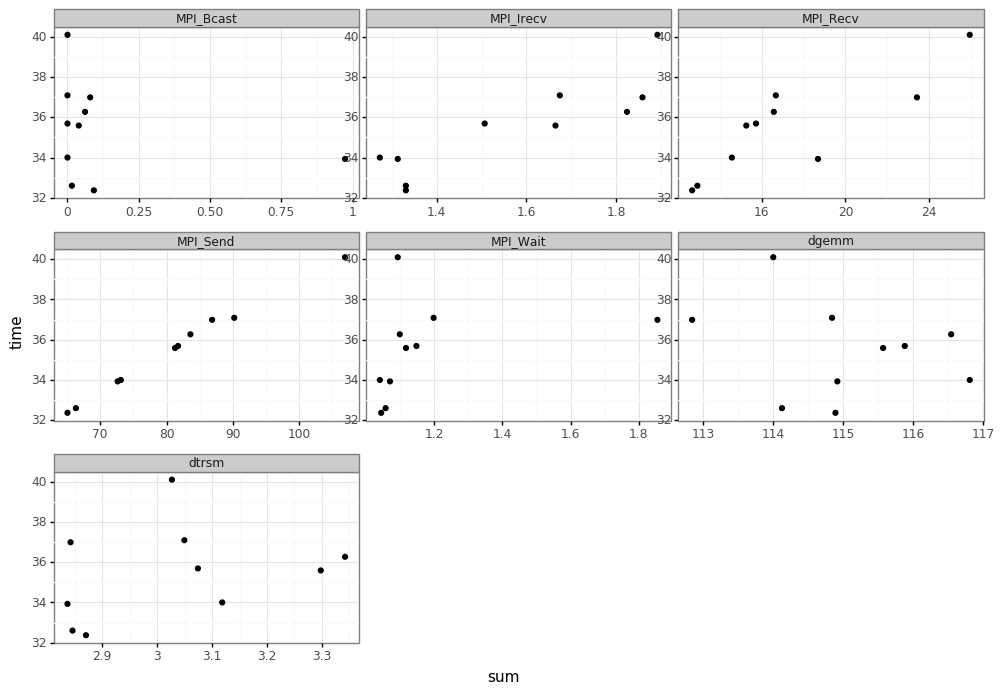

<ggplot: (-9223363249456239058)>

In [5]:
ggplot(df, aes(x='sum', y='time')) + geom_point() + facet_wrap('function', scales='free') + theme_bw() + theme(subplots_adjust={'hspace':0.3})  # the subplots_adjust is to fix a display bug...

## Performance variability of dgemm

In [6]:
dgemm = traces[traces['function'] == 'dgemm'].copy()
dgemm['size_product'] = dgemm.m * dgemm.n * dgemm.k
dgemm = dgemm[dgemm.size_product > 0]
dgemm.head()

,end,file,function,k,kind,line,m,msg_size,n,rank,start,mode,rank+1,duration,exp_id,size_product
1,7.684327,../HPL_pdrpanrlT.c,dgemm,2.0,BLAS,224.0,25038.0,-1,2.0,0,7.68421,reality,1,0.000117,0,100152.0
5,7.712497,../HPL_pdrpanrlT.c,dgemm,4.0,BLAS,224.0,25036.0,-1,4.0,0,7.71222,reality,1,0.000277,0,400576.0
7,7.712767,../HPL_pdrpanrlT.c,dgemm,2.0,BLAS,224.0,25034.0,-1,2.0,0,7.71267,reality,1,0.000097,0,100136.0
13,7.713194,../HPL_pdrpanrlT.c,dgemm,8.0,BLAS,224.0,25032.0,-1,8.0,0,7.71304,reality,1,0.000154,0,1602048.0
15,7.713497,../HPL_pdrpanrlT.c,dgemm,2.0,BLAS,224.0,25030.0,-1,2.0,0,7.71340,reality,1,0.000097,0,100120.0


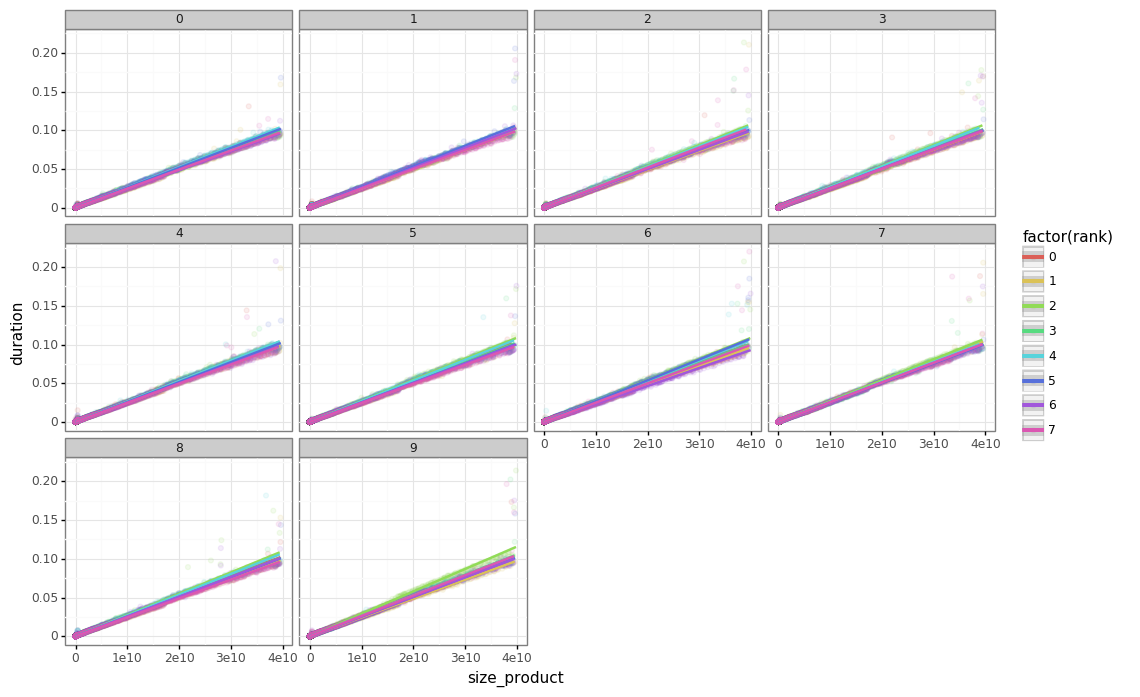

<ggplot: (8787303240957)>

In [7]:
ggplot(dgemm, aes(x='size_product', y='duration', color='factor(rank)')) + geom_point(alpha=0.1) + geom_smooth(method='lm') + facet_wrap('exp_id') + theme_bw()

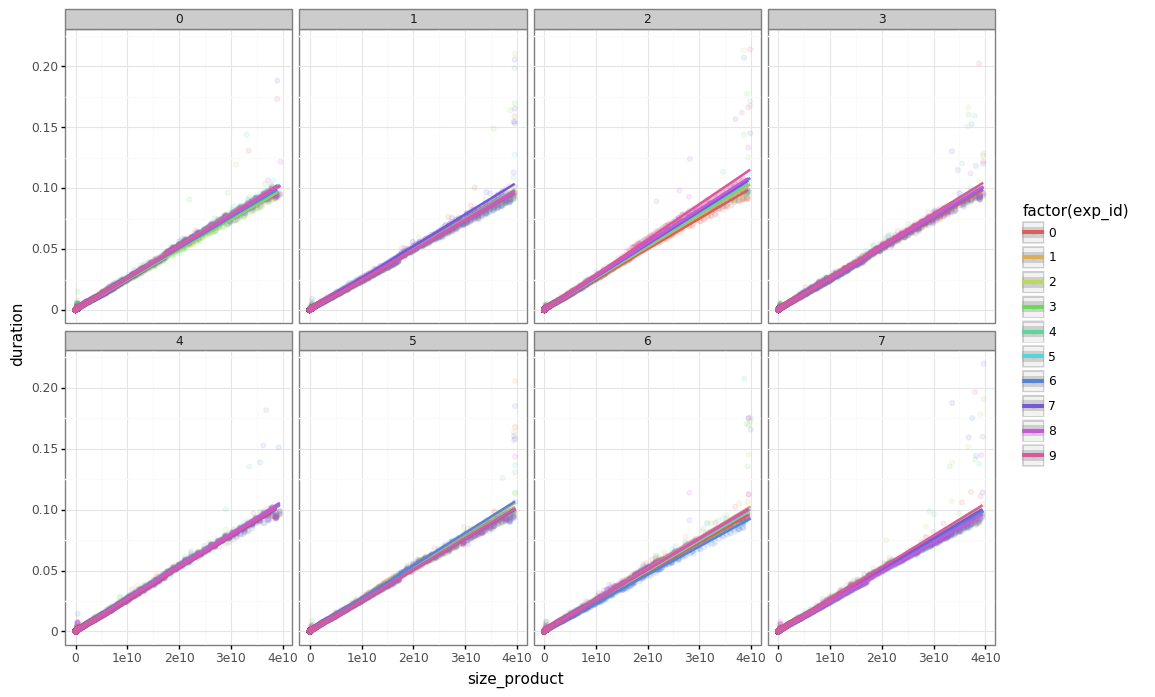

<ggplot: (8787278243788)>

In [8]:
ggplot(dgemm, aes(x='size_product', y='duration', color='factor(exp_id)')) + geom_point(alpha=0.1) + geom_smooth(method='lm') + facet_wrap('rank', nrow=2) + theme_bw()